In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats
import os


In [2]:
# Add tensorboard stuff
# %load_ext tensorboard
# import datetime

# !rm -rf ./logs/


In [3]:
#fix all seeds for random number generators
# Set seed value
seed_value = 9
import os
os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
tf.random.set_seed(seed_value)# 5. Configure a new global `tensorflow` session

# TODO need to add session thing for tensorflow

# Read Depth Camera

In [4]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#             gray_frame = frame/np.maximum(np.max(frame),255) keep as int8 for memory savings
            gray_frame = frame
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [5]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [6]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [7]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)

n_test = (1,2,24,30,31,32,33,35,1,3)
nw_resize = 2
nh_resize = 2
xtemp = {}
show_video = 0

subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
        
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
#     train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    train_dcamera_path = os.path.join(data_dir , 'depth_processed_'+subj[i]+'_test'+str(n_test[i])+'.avi')
    xtemp[i] = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize).astype('uint8')
    


In [8]:
tlen=0
for x in range(len(xtemp)):
    tlen+= xtemp[x].shape[0]
xrun_cum = 0
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]),dtype='uint8')
for i in range (len(xtemp)):
    xrun_n = len(xtemp[i])
    x_train[xrun_cum:xrun_cum+xrun_n,:,:,:] = xtemp[i][:xrun_n,:,:,:]
    xrun_cum += xrun_n

In [9]:
x_train.shape

(153421, 60, 80, 3)

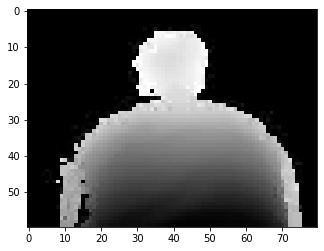

In [10]:
plt.imshow(x_train[153418])

In [11]:
print(x_train.shape)
del xtemp

(153421, 60, 80, 3)


# read fcss data

In [12]:

n_test = (1,2,24,30,31,32,33,35,1,3)
date = ('12_2_2020','12_11_2020','11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020','12_2_2020','12_11_2020')
subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
subjwgt = [61,61, 67, 67, 67, 67, 67, 67, 70, 70]
subjht = [180, 180, 174, 174, 174, 174, 174, 174, 170, 170]
xfcss_gt = {}
yrun = 0
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    fcss_data_dir = os.path.join(data_dir , 'fcss_processed_'+subj[i]+'_' + test_str + '_' + date[i] + '.txt')
    xfcss_gttemp = pd.read_csv(fcss_data_dir)/subjwgt[i]*subjht[i]**2
    xfcss_gt[i]=xfcss_gttemp
#     xfcss_gt[i]['weight'] = subjwgt[i]# hacky but will work for now
#     xfcss_gt[i]['height'] = subjht[i]# hacky but will work for now
    if i==0:
        xfcss_train=xfcss_gttemp
    else:
        xfcss_train = pd.concat([xfcss_train,xfcss_gt[i]],axis=0)
del xfcss_gt

In [13]:
xfcss_train

,Fz bottom (kg),Fz left (kg),Fz right (kg),Fx left (kg),Fx right (kg),Fy (kg)
0,-26833.573770,-6124.131148,-6421.573770,4865.311475,6352.524590,127.475410
1,-26727.344262,-6150.688525,-6490.622951,4865.311475,6315.344262,100.918033
2,-26652.983607,-6193.180328,-6570.295082,4854.688525,6294.098361,84.983607
3,-26605.180328,-6246.295082,-6628.721311,4860.000000,6315.344262,74.360656
4,-26605.180328,-6288.786885,-6687.147541,4854.688525,6368.459016,74.360656
...,...,...,...,...,...,...
23050,-20539.642857,-7877.314286,-7183.714286,4751.985714,5276.314286,169.271429
23051,-20552.028571,-7798.871429,-7175.457143,4785.014286,5164.842857,202.300000
23052,-20539.642857,-7695.657143,-7179.585714,4801.528571,5028.600000,222.942857
23053,-20527.257143,-7600.700000,-7191.971429,4830.428571,4908.871429,231.200000


# Read Output Data


In [14]:

n_test = (1,2,24,30,31,32,33,35,1,3)
date = ('12_2_2020','12_11_2020','11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020','12_2_2020','12_11_2020')
subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
y_gt = {}
yrun = 0
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    qtm_file_data_dir = os.path.join(data_dir , 'qtm_processed_'+subj[i]+'_test' + str(n_test[i]) + '_' + date[i] + '.txt')
    y_gt[i] = read_output_data(qtm_file_data_dir,theta_interest).values

    

# tlen = len(y_gt[0])+len(y_gt[1])+len(y_gt[2])+len(y_gt[3])+len(y_gt[4])+len(y_gt[5])
# y_train = np.zeros((tlen,1))
# xrun = len(y_gt[0])
# y_train[:xrun] = y_gt[0][:xrun]
# xrun1 = xrun + len(y_gt[1])
# y_train[xrun:xrun1]=y_gt[1][:xrun1-xrun]
# xrun2 = xrun1 + len(y_gt[2])
# y_train[xrun1:xrun2] = y_gt[2][:xrun2-xrun1]
# xrun3 = xrun2 + len(y_gt[3])
# y_train[xrun2:xrun3] = y_gt[3][:xrun3-xrun2]
# xrun4 = xrun3 + len(y_gt[4])
# y_train[xrun3:xrun4] = y_gt[4][:xrun4-xrun3]
# xrun5 = xrun4 + len(y_gt[5])
# y_train[xrun4:xrun5] = y_gt[5][:xrun5-xrun4]
# del y_gt

In [15]:
tlen=0
for x in range(len(y_gt)):
    tlen+= y_gt[x].shape[0]
yrun_cum = 0
y_train = np.zeros((tlen,1))
for i in range (len(y_gt)):
    yrun_n = len(y_gt[i])
    y_train[yrun_cum:yrun_cum+yrun_n] = y_gt[i][:]
    yrun_cum += yrun_n

In [16]:
# Saturate output
def saturate(theta, min_val, max_val):
    for i in range(len(theta)):
        if theta[i] < min_val:
            theta[i] = min_val
            continue
        if theta[i] > max_val:
            theta[i] = max_val
            continue
    return theta
            
min_val = -50
max_val = 50
    
y_train = saturate(y_train, min_val, max_val)

In [17]:
print(x_train.shape)
print(xfcss_train.shape)
print(y_train.shape)

(153421, 60, 80, 3)
(153421, 6)
(153421, 1)


In [18]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [42]:
Trainset = x_train[rannums,:]
Trainset2 = xfcss_train.values[rannums,:]
Testset = x_train[test_set,:]
Testset2 = xfcss_train.values[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [20]:
sc_X2 = StandardScaler()
sc_y = StandardScaler()

In [21]:
Xtrainz = Trainset
Xtrainz2 = Trainset2
ytrainz = Trainy
X = Xtrainz
X2 = sc_X2.fit_transform(Xtrainz2)
y = sc_y.fit_transform(ytrainz)

In [22]:
#make validation data available to model.fit
Xvalid = Testset
Xvalid2 = sc_X2.transform(Testset2)
y_valid = Testy
y_valid = sc_y.transform(y_valid)


In [23]:
# clear up some used variables
del Trainset
del Trainset2
del Testset
del Testset2


# Regress using Neural Network

In [24]:
x_train.shape

(153421, 60, 80, 3)

In [25]:
# Create Neural Netowrk

from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, concatenate, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute, Flatten
from tensorflow.keras.models import Model
# dropout_rate = 0.2

model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_start2 = Input(shape=(xfcss_train.shape[1],))
model_cnn = model_start
model_perc = model_start2

model_cnn = Conv2D(filters=8, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Conv2D(filters=8, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(100)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(100)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same',use_bias=False)(model_cnn)
model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Flatten()(model_cnn)
# model_perc = Flatten()(model_perc)
# model_cnn = Activation('relu')(model_cnn)

model_cnn = Dense(100)(model_cnn)
model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_comb = concatenate([model_cnn,model_perc],axis=-1)

model_comb = Dense(128)(model_comb)
# model_comb = BatchNormalization()(model_comb)
model_comb = Activation('relu')(model_comb)
# model_comb = Dropout(dropout_rate)(model_comb)

output = Dense(1)(model_comb)
output = Activation('linear', name='thetaz_out')(output)
model = Model(inputs=[model_start,model_start2],outputs=output)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])


# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50,restore_best_weights=True) #Moving to 1000 patience.


In [26]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 80, 8)    216         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 80, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 60, 80, 8)    0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [27]:
print(tf.__version__)

2.3.1


In [28]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
from tensorflow.keras import layers
with tf.device('/device:CPU:0'):
    data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomRotation(0.05),
        layers.experimental.preprocessing.RandomZoom(height_factor = (-0.2,0.2),
                                               width_factor = (-0.2,0.2), 
                                               fill_mode = 'constant'),
        ], 
        name='data_augmentation')

# create data generator
def get_generator_cyclic(features1, features2, labels, batch_size=256):
    while True:
        for n in range(int(len(features1)/batch_size)):
            X = features1[n*batch_size: (n+1)*batch_size]
            with tf.device('/device:CPU:0'): #to prevent hogging limited gpu space
                augmented_images = data_augmentation(X)
                Xnew =  tf.cast(augmented_images,tf.float64)/255
            yield [Xnew, features2[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size]]
        permuted = np.random.permutation(len(features1))
        features1 = features1[permuted]
        features2 = features2[permuted]
        labels = labels[permuted]


In [30]:
def scheduler(epoch, lr):
    if e < 200: #very hacky
        return 0.001
    else:
        if e%10==0 & batches==0:
            return lr * 0.9
        else:
            return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [31]:
from datetime import datetime
batch_size = 128
batch_mult = 4
readin = int(batch_size*batch_mult)
epochs = int(300)
training_generator = get_generator_cyclic(X,X2,y,readin)
# test_generator = get_generator_cyclic(Xvalid,Xvalid2,y_valid,readin)
for e in range(epochs):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print('Epoch', e,'Time: ', current_time)
    batches = 0
    while batches< len(X)/readin:
        Xtrain_1, Xtrain_2, ytrain_1 = next(training_generator)
#         Xtest_1, Xtest_2, ytest_1 =next(test_generator)
#         model.fit([Xtrain_1, Xtrain_2], ytrain_1, callbacks = [callback],validation_data = ([Xtest_1,Xtest_2], ytest_1),batch_size=batch_size,verbose = 0)
        model.fit([Xtrain_1, Xtrain_2], ytrain_1, callbacks = [callback],batch_size=batch_size,verbose = 0)
        batches += 1
    
    #calculates and prints the running validation once per epoch
    losssc, msesc, maesc = model.evaluate([Xvalid/255.,Xvalid2],y_valid,verbose=0)
    mae = maesc*(sc_y.var_[0])**0.5
    print('Mean absolute error at {:4.0f} is: {:4.2f}'.format(e,mae))     

Epoch 0 Time:  19:55:45
Mean absolute error at    0 is: 9.59
Epoch 1 Time:  19:57:06
Mean absolute error at    1 is: 4.69
Epoch 2 Time:  19:58:23
Mean absolute error at    2 is: 5.03
Epoch 3 Time:  19:59:40
Mean absolute error at    3 is: 4.52
Epoch 4 Time:  20:00:58
Mean absolute error at    4 is: 4.21
Epoch 5 Time:  20:02:15
Mean absolute error at    5 is: 4.18
Epoch 6 Time:  20:03:33
Mean absolute error at    6 is: 4.15
Epoch 7 Time:  20:04:51
Mean absolute error at    7 is: 4.39
Epoch 8 Time:  20:06:08
Mean absolute error at    8 is: 4.17
Epoch 9 Time:  20:07:26
Mean absolute error at    9 is: 3.74
Epoch 10 Time:  20:08:43
Mean absolute error at   10 is: 4.08
Epoch 11 Time:  20:10:01
Mean absolute error at   11 is: 3.76
Epoch 12 Time:  20:11:18
Mean absolute error at   12 is: 3.65
Epoch 13 Time:  20:12:36
Mean absolute error at   13 is: 3.56
Epoch 14 Time:  20:13:53
Mean absolute error at   14 is: 3.47
Epoch 15 Time:  20:15:10
Mean absolute error at   15 is: 3.43
Epoch 16 Time:  20

Mean absolute error at  132 is: 2.26
Epoch 133 Time:  22:46:07
Mean absolute error at  133 is: 2.32
Epoch 134 Time:  22:47:24
Mean absolute error at  134 is: 2.28
Epoch 135 Time:  22:48:40
Mean absolute error at  135 is: 2.34
Epoch 136 Time:  22:49:57
Mean absolute error at  136 is: 2.21
Epoch 137 Time:  22:51:13
Mean absolute error at  137 is: 2.25
Epoch 138 Time:  22:52:30
Mean absolute error at  138 is: 2.27
Epoch 139 Time:  22:53:46
Mean absolute error at  139 is: 2.24
Epoch 140 Time:  22:55:03
Mean absolute error at  140 is: 2.32
Epoch 141 Time:  22:56:20
Mean absolute error at  141 is: 2.24
Epoch 142 Time:  22:57:36
Mean absolute error at  142 is: 2.26
Epoch 143 Time:  22:58:53
Mean absolute error at  143 is: 2.28
Epoch 144 Time:  23:00:09
Mean absolute error at  144 is: 2.21
Epoch 145 Time:  23:01:26
Mean absolute error at  145 is: 2.19
Epoch 146 Time:  23:02:42
Mean absolute error at  146 is: 2.20
Epoch 147 Time:  23:04:00
Mean absolute error at  147 is: 2.31
Epoch 148 Time:  2

Mean absolute error at  263 is: 1.98
Epoch 264 Time:  01:34:47
Mean absolute error at  264 is: 1.98
Epoch 265 Time:  01:36:04
Mean absolute error at  265 is: 1.98
Epoch 266 Time:  01:37:21
Mean absolute error at  266 is: 1.98
Epoch 267 Time:  01:38:39
Mean absolute error at  267 is: 1.98
Epoch 268 Time:  01:39:56
Mean absolute error at  268 is: 1.98
Epoch 269 Time:  01:41:13
Mean absolute error at  269 is: 1.98
Epoch 270 Time:  01:42:31
Mean absolute error at  270 is: 1.98
Epoch 271 Time:  01:43:48
Mean absolute error at  271 is: 1.98
Epoch 272 Time:  01:45:05
Mean absolute error at  272 is: 1.98
Epoch 273 Time:  01:46:23
Mean absolute error at  273 is: 1.98
Epoch 274 Time:  01:47:40
Mean absolute error at  274 is: 1.98
Epoch 275 Time:  01:48:58
Mean absolute error at  275 is: 1.98
Epoch 276 Time:  01:50:15
Mean absolute error at  276 is: 1.98
Epoch 277 Time:  01:51:33
Mean absolute error at  277 is: 1.98
Epoch 278 Time:  01:52:50
Mean absolute error at  278 is: 1.98
Epoch 279 Time:  0

In [34]:
# continue training
training_generator = get_generator_cyclic(X,X2,y,readin)
for e in range(epochs):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print('Epoch', e,'Time: ', current_time)
    batches = 0
    while batches<= len(X)/readin:
        Xtrain_1, Xtrain_2, ytrain_1 = next(training_generator)
#         Xtest_1, Xtest_2, ytest_1 =next(test_generator)
#         model.fit([Xtrain_1, Xtrain_2], ytrain_1, callbacks = [callback],validation_data = ([Xtest_1,Xtest_2], ytest_1),batch_size=batch_size,verbose = 0)
        model.fit([Xtrain_1, Xtrain_2], ytrain_1, callbacks = [callback],batch_size=batch_size,verbose = 0)
        batches += 1
        
    losssc, msesc, maesc = model.evaluate([Xvalid/255.,Xvalid2],y_valid,verbose=0)
    mae = maesc*(sc_y.var_[0])**0.5
    print('Mean absolute error at {:4.0f} is: {:4.2f}'.format(e,mae))     

Epoch 0 Time:  02:35:13
Mean absolute error at    0 is: 2.12
Epoch 1 Time:  02:36:30
Mean absolute error at    1 is: 2.09
Epoch 2 Time:  02:37:51
Mean absolute error at    2 is: 2.12
Epoch 3 Time:  02:39:09
Mean absolute error at    3 is: 2.07
Epoch 4 Time:  02:40:26
Mean absolute error at    4 is: 2.09
Epoch 5 Time:  02:41:43
Mean absolute error at    5 is: 2.10
Epoch 6 Time:  02:43:00
Mean absolute error at    6 is: 2.13
Epoch 7 Time:  02:44:17
Mean absolute error at    7 is: 2.13
Epoch 8 Time:  02:45:34
Mean absolute error at    8 is: 2.12
Epoch 9 Time:  02:46:51
Mean absolute error at    9 is: 2.09
Epoch 10 Time:  02:48:07
Mean absolute error at   10 is: 2.10
Epoch 11 Time:  02:49:24
Mean absolute error at   11 is: 2.07
Epoch 12 Time:  02:50:41
Mean absolute error at   12 is: 2.10
Epoch 13 Time:  02:51:58
Mean absolute error at   13 is: 2.11
Epoch 14 Time:  02:53:15
Mean absolute error at   14 is: 2.06
Epoch 15 Time:  02:54:32
Mean absolute error at   15 is: 2.08
Epoch 16 Time:  02

Mean absolute error at  132 is: 1.95
Epoch 133 Time:  05:26:13
Mean absolute error at  133 is: 1.97
Epoch 134 Time:  05:27:29
Mean absolute error at  134 is: 1.97
Epoch 135 Time:  05:28:44
Mean absolute error at  135 is: 1.98
Epoch 136 Time:  05:30:00
Mean absolute error at  136 is: 1.96
Epoch 137 Time:  05:31:16
Mean absolute error at  137 is: 2.02
Epoch 138 Time:  05:32:31
Mean absolute error at  138 is: 2.03
Epoch 139 Time:  05:33:47
Mean absolute error at  139 is: 1.99
Epoch 140 Time:  05:35:03
Mean absolute error at  140 is: 1.98
Epoch 141 Time:  05:36:19
Mean absolute error at  141 is: 1.96
Epoch 142 Time:  05:37:34
Mean absolute error at  142 is: 2.00
Epoch 143 Time:  05:38:50
Mean absolute error at  143 is: 1.98
Epoch 144 Time:  05:40:06
Mean absolute error at  144 is: 2.00
Epoch 145 Time:  05:41:22
Mean absolute error at  145 is: 1.98
Epoch 146 Time:  05:42:38
Mean absolute error at  146 is: 2.02
Epoch 147 Time:  05:43:54
Mean absolute error at  147 is: 1.95
Epoch 148 Time:  0

Mean absolute error at  263 is: 1.81
Epoch 264 Time:  08:11:38
Mean absolute error at  264 is: 1.81
Epoch 265 Time:  08:12:53
Mean absolute error at  265 is: 1.81
Epoch 266 Time:  08:14:09
Mean absolute error at  266 is: 1.81
Epoch 267 Time:  08:15:25
Mean absolute error at  267 is: 1.81
Epoch 268 Time:  08:16:41
Mean absolute error at  268 is: 1.81
Epoch 269 Time:  08:17:56
Mean absolute error at  269 is: 1.81
Epoch 270 Time:  08:19:12
Mean absolute error at  270 is: 1.81
Epoch 271 Time:  08:20:27
Mean absolute error at  271 is: 1.81
Epoch 272 Time:  08:21:43
Mean absolute error at  272 is: 1.81
Epoch 273 Time:  08:22:58
Mean absolute error at  273 is: 1.81
Epoch 274 Time:  08:24:14
Mean absolute error at  274 is: 1.81
Epoch 275 Time:  08:25:29
Mean absolute error at  275 is: 1.81
Epoch 276 Time:  08:26:45
Mean absolute error at  276 is: 1.81
Epoch 277 Time:  08:28:01
Mean absolute error at  277 is: 1.81
Epoch 278 Time:  08:29:16
Mean absolute error at  278 is: 1.81
Epoch 279 Time:  0

In [37]:
#change settings for learning rate decay
def scheduler(epoch, lr):
    if e < 200: #very hacky
        return 0.001
    else:
        if e%10==0 & batches==0:
            return lr * 0.99
        else:
            return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [38]:
training_generator = get_generator_cyclic(X,X2,y,readin)
for e in range(epochs):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print('Epoch', e,'Time: ', current_time)
    batches = 0
    while batches<= len(X)/readin:
        Xtrain_1, Xtrain_2, ytrain_1 = next(training_generator)
#         Xtest_1, Xtest_2, ytest_1 =next(test_generator)
#         model.fit([Xtrain_1, Xtrain_2], ytrain_1, callbacks = [callback],validation_data = ([Xtest_1,Xtest_2], ytest_1),batch_size=batch_size,verbose = 0)
        model.fit([Xtrain_1, Xtrain_2], ytrain_1, callbacks = [callback],batch_size=batch_size,verbose = 0)
        batches += 1
        
    losssc, msesc, maesc = model.evaluate([Xvalid/255.,Xvalid2],y_valid,verbose=0)
    mae = maesc*(sc_y.var_[0])**0.5
    print('Mean absolute error at {:4.0f} is: {:4.2f}'.format(e,mae))   

Epoch 0 Time:  11:00:17
Mean absolute error at    0 is: 1.93
Epoch 1 Time:  11:01:33
Mean absolute error at    1 is: 1.95
Epoch 2 Time:  11:02:49
Mean absolute error at    2 is: 1.92
Epoch 3 Time:  11:04:05
Mean absolute error at    3 is: 1.90
Epoch 4 Time:  11:05:20
Mean absolute error at    4 is: 1.90
Epoch 5 Time:  11:06:37
Mean absolute error at    5 is: 1.94
Epoch 6 Time:  11:07:53
Mean absolute error at    6 is: 1.96
Epoch 7 Time:  11:09:08
Mean absolute error at    7 is: 1.89
Epoch 8 Time:  11:10:24
Mean absolute error at    8 is: 1.98
Epoch 9 Time:  11:11:40
Mean absolute error at    9 is: 1.94
Epoch 10 Time:  11:12:56
Mean absolute error at   10 is: 1.92
Epoch 11 Time:  11:14:12
Mean absolute error at   11 is: 1.92
Epoch 12 Time:  11:15:27
Mean absolute error at   12 is: 1.93
Epoch 13 Time:  11:16:43
Mean absolute error at   13 is: 1.94
Epoch 14 Time:  11:17:59
Mean absolute error at   14 is: 1.94
Epoch 15 Time:  11:19:15
Mean absolute error at   15 is: 1.91
Epoch 16 Time:  11

Mean absolute error at  132 is: 1.88
Epoch 133 Time:  13:48:40
Mean absolute error at  133 is: 1.87
Epoch 134 Time:  13:49:55
Mean absolute error at  134 is: 1.92
Epoch 135 Time:  13:51:11
Mean absolute error at  135 is: 1.95
Epoch 136 Time:  13:52:27
Mean absolute error at  136 is: 1.90
Epoch 137 Time:  13:53:43
Mean absolute error at  137 is: 1.88
Epoch 138 Time:  13:54:59
Mean absolute error at  138 is: 1.86
Epoch 139 Time:  13:56:15
Mean absolute error at  139 is: 1.87
Epoch 140 Time:  13:57:31
Mean absolute error at  140 is: 1.89
Epoch 141 Time:  13:58:47
Mean absolute error at  141 is: 1.88
Epoch 142 Time:  14:00:03
Mean absolute error at  142 is: 1.89
Epoch 143 Time:  14:01:19
Mean absolute error at  143 is: 1.87
Epoch 144 Time:  14:02:34
Mean absolute error at  144 is: 1.86
Epoch 145 Time:  14:03:50
Mean absolute error at  145 is: 1.88
Epoch 146 Time:  14:05:07
Mean absolute error at  146 is: 1.93
Epoch 147 Time:  14:06:22
Mean absolute error at  147 is: 1.84
Epoch 148 Time:  1

Mean absolute error at  263 is: 1.66
Epoch 264 Time:  16:36:37
Mean absolute error at  264 is: 1.66
Epoch 265 Time:  16:37:55
Mean absolute error at  265 is: 1.66
Epoch 266 Time:  16:39:15
Mean absolute error at  266 is: 1.66
Epoch 267 Time:  16:40:36
Mean absolute error at  267 is: 1.67
Epoch 268 Time:  16:41:58
Mean absolute error at  268 is: 1.66
Epoch 269 Time:  16:43:19
Mean absolute error at  269 is: 1.67
Epoch 270 Time:  16:44:38
Mean absolute error at  270 is: 1.67
Epoch 271 Time:  16:45:56
Mean absolute error at  271 is: 1.66
Epoch 272 Time:  16:47:14
Mean absolute error at  272 is: 1.66
Epoch 273 Time:  16:48:31
Mean absolute error at  273 is: 1.66
Epoch 274 Time:  16:49:49
Mean absolute error at  274 is: 1.67
Epoch 275 Time:  16:51:07
Mean absolute error at  275 is: 1.67
Epoch 276 Time:  16:52:24
Mean absolute error at  276 is: 1.67
Epoch 277 Time:  16:53:44
Mean absolute error at  277 is: 1.67
Epoch 278 Time:  16:55:05
Mean absolute error at  278 is: 1.67
Epoch 279 Time:  1

In [ ]:
#%tensorboard --logdir logs/fit

In [ ]:
def plot_loss(history):
    
    v1 = history.history['mae']*np.sqrt(sc_y.var_)
    v2 = history.history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history.history['mse']*sc_y.var_
    v4 = history.history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

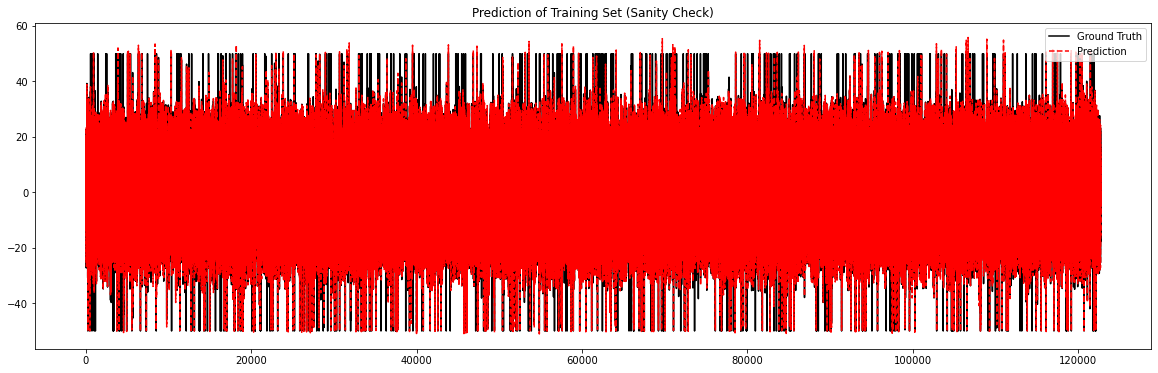

Average error is -0.01 degrees
Root Mean Squared Error is 1.15 degrees
Mean Absolute Error is 1.15 degrees


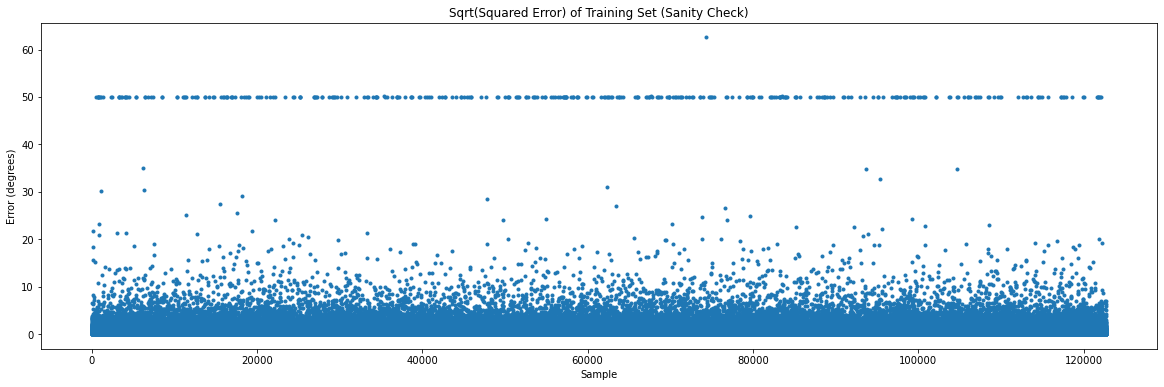

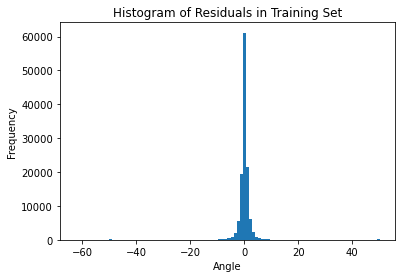

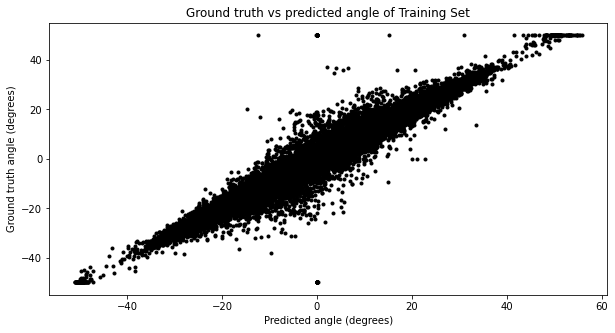

In [44]:

# sanity check with 80% data
Xtrainz = Trainset/255.
Xtrainz2 = sc_X2.transform(Trainset2)
y_pred = model.predict([Xtrainz,Xtrainz2])
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

In [ ]:
# cheap way to check mse for test set
losssc, msesc, maesc = model.evaluate([Xvalid/255.,Xvalid2],y_valid)
mae = maesc*(sc_y.var_)**0.5
print('Mean absolute error is: {:4.2f}'.format(mae[0]))

In [ ]:
losssc, msesc, maesc = model.evaluate([Xvalid/255.,Xvalid2],y_valid)
mae = maesc*(sc_y.var_[0])**0.5
print('Mean absolute error is: {:4.2f}'.format(mae))

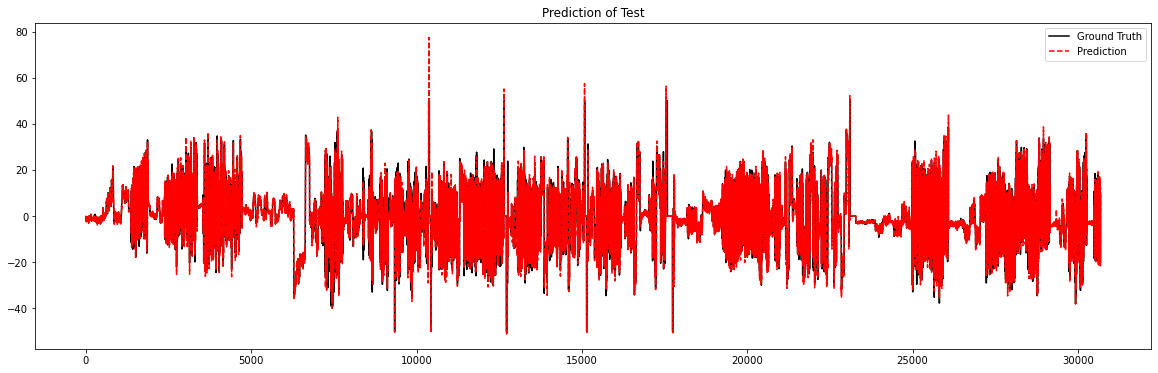

Average error is -0.01 degrees
Root Mean Squared Error is 1.66 degrees
Mean Absolute Error is 1.66 degrees


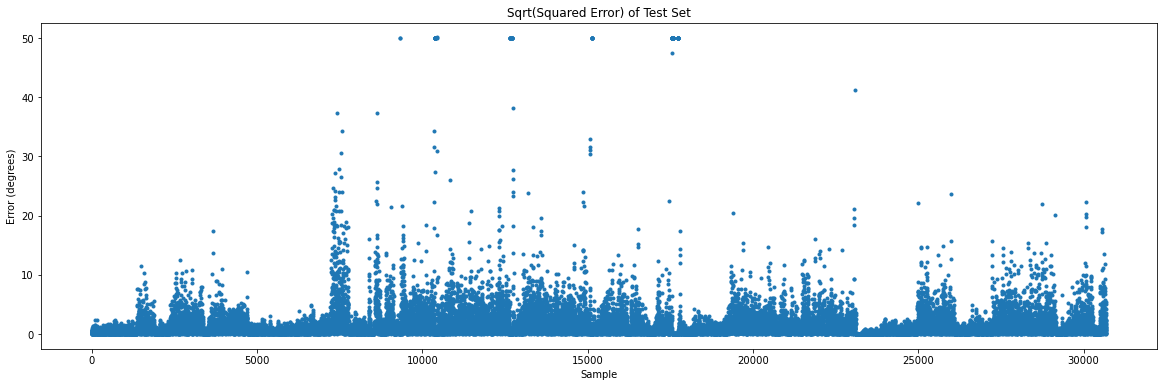

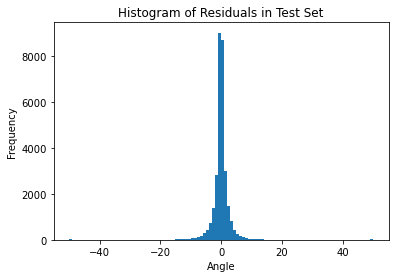

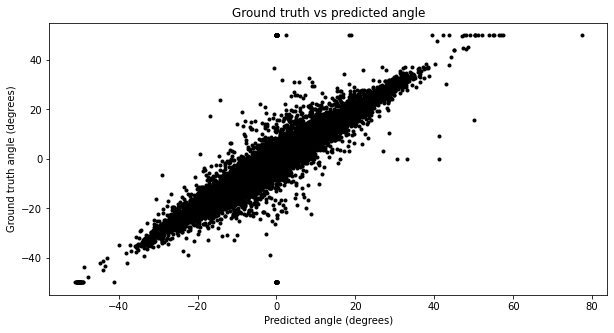

In [43]:
# Redo test set
Xtest = Testset/255.
Xtest2 = sc_X2.transform(Testset2)
y_pred = model.predict([Xtest,Xtest2])
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [40]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthforcemodelparam_cnn3v26_r3_pb.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
#     modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
#         pickle.dump([randata,sc_y,sc_X2,modelhistory], file)
          pickle.dump([randata,sc_y,sc_X2], file)
        
#     !mkdir -p saved_model
#     model.save('saved_model/cnn3v22')

In [39]:
model.save('saved_model/cnn3v26_r3')

INFO:tensorflow:Assets written to: saved_model/cnn3v26_r3\assets


In [45]:
# 
%matplotlib qt

In [46]:
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()